In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler


In [2]:
print("""
# #####################################################################################################################
# RNN on a Time Series - Part One(1)
# #####################################################################################################################
""")



# #####################################################################################################################
# RNN on a Time Series - Part One(1)
# #####################################################################################################################



In [3]:
# With index_col=0, make the first column the index column and with parse_dates=True, try to parse the index column
# as datetime values.
df = pd.read_csv('../../../notebooks/Data/TimeSeriesData/Alcohol_Sales.csv', index_col=0, parse_dates=True)
df

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


In [4]:
df = df.dropna()
y = df.iloc[:, 0].values.astype(float)
y

array([ 3459.,  3458.,  4002.,  4564.,  4221.,  4529.,  4466.,  4137.,
        4126.,  4259.,  4240.,  4936.,  3031.,  3261.,  4160.,  4377.,
        4307.,  4696.,  4458.,  4457.,  4364.,  4236.,  4500.,  4974.,
        3075.,  3377.,  4443.,  4261.,  4460.,  4985.,  4324.,  4719.,
        4374.,  4248.,  4784.,  4971.,  3370.,  3484.,  4269.,  3994.,
        4715.,  4974.,  4223.,  5000.,  4235.,  4554.,  4851.,  4826.,
        3699.,  3983.,  4262.,  4619.,  5219.,  4836.,  4941.,  5062.,
        4365.,  5012.,  4850.,  5097.,  3758.,  3825.,  4454.,  4635.,
        5210.,  5057.,  5231.,  5034.,  4970.,  5342.,  4831.,  5965.,
        3796.,  4019.,  4898.,  5090.,  5237.,  5447.,  5435.,  5107.,
        5515.,  5583.,  5346.,  6286.,  4032.,  4435.,  5479.,  5483.,
        5587.,  6176.,  5621.,  5889.,  5828.,  5849.,  6180.,  6771.,
        4243.,  4952.,  6008.,  5353.,  6435.,  6673.,  5636.,  6630.,
        5887.,  6322.,  6520.,  6678.,  5082.,  5216.,  5893.,  5894.,
      

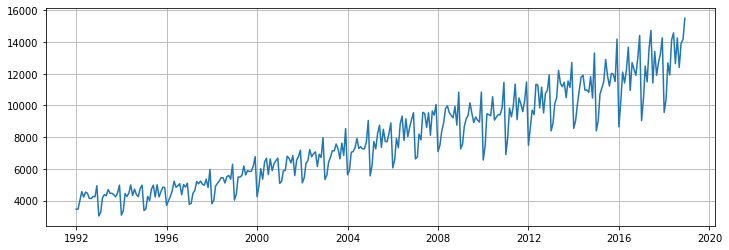

In [5]:
# Plot current dataset.
plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(np.arange('1992-01-01', '2019-01-01', dtype='datetime64[M]'), y[:324])

In [6]:
def train_split(seq, ws):
    out = []
    L = len(seq)
    for i in range(L - ws):
        window = seq[i:i + ws]
        label = seq[i + ws:i + ws + 1]
        out.append((window, label))
    return out

In [25]:
window_size = 12

train_set = y[:-window_size]
test_set = y[-window_size:]

In [8]:
# Normalize the data sets in order for faster and accurate convergence and void data leakage between train
# and test data sets.
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
train_data = torch.tensor(train_norm).float()

train_data = train_split(train_data, window_size)
train_data[:2]

[(tensor([[-0.9268],
          [-0.9270],
          [-0.8340],
          [-0.7379],
          [-0.7966],
          [-0.7439],
          [-0.7547],
          [-0.8109],
          [-0.8128],
          [-0.7901],
          [-0.7933],
          [-0.6743]]),
  tensor([[-1.]])),
 (tensor([[-0.9270],
          [-0.8340],
          [-0.7379],
          [-0.7966],
          [-0.7439],
          [-0.7547],
          [-0.8109],
          [-0.8128],
          [-0.7901],
          [-0.7933],
          [-0.6743],
          [-1.0000]]),
  tensor([[-0.9607]]))]

In [9]:
print("""
# #####################################################################################################################
# RNN on a Time Series - Part Two(2)
# #####################################################################################################################
""")


# #####################################################################################################################
# RNN on a Time Series - Part Two(2)
# #####################################################################################################################



In [10]:
class LSTMNetwork(nn.Module):

    def __init__(self, in_features=1, hidden_size=100, out_features=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=in_features, hidden_size=hidden_size, num_layers=2)
        self.linear = nn.Linear(in_features=hidden_size, out_features=out_features)
        self.hidden = (torch.zeros(2, 1, hidden_size), torch.zeros(2, 1, hidden_size))

    def forward(self, seq):
        lstm, _ = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        seq = self.linear(lstm.view(len(lstm), -1))
        return seq[-1]


torch.manual_seed(101)
model = LSTMNetwork()
model

LSTMNetwork(
  (lstm): LSTM(1, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [181]:
# Train the model.
epoch = 100

start = time.time()
for i in range(epoch):
    i += 1
    loss = 0
    for seq, label in train_data:

        model.hidden = (torch.zeros(2, 1, model.hidden_size), torch.zeros(2, 1, model.hidden_size))
        optimizer.zero_grad()

        y_pred = model(seq)
        loss = criterion(y_pred, label.view(-1))

        loss.backward()
        optimizer.step()

    print(f'epoch: {i}, loss: {loss}')

duration = time.time() - start
print(f'Duration: {duration / 60} minutes')

KeyboardInterrupt: 

In [ ]:
# De-normalize the training values and test with test dataset.
future = 12

preds = train_norm[-window_size:].tolist()
model.eval()
for f in range(future):
    f += 1
    seq = torch.tensor(preds[-window_size:])
    with torch.no_grad():

        model.hidden = (torch.zeros(5, 1, model.hidden_size), torch.zeros(5, 1, model.hidden_size))
        y_pred = model(seq)

        preds.append(y_pred)
preds

In [ ]:
# Inverse the normalization.
true_prediction = scaler.inverse_transform(np.array(preds[-window_size:]).reshape(-1, 1))
# These true predictions and actual values should be even almost.
print(true_prediction, y[-window_size:])

In [ ]:
# Create range for date and time with numpy.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]')
print(x)

In [ ]:
# Plot the predictions.
fig = plt.figure(figsize=(12, 4))
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()
plt.plot(df.iloc[:, 0])
plt.plot(x, true_prediction)
plt.show()

In [ ]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_prediction)
plt.show()

In [29]:
# Forecast into the unknown future (Train with entire dataset and forecast to unknown future).
train_norm_all = scaler.fit_transform(y.reshape(-1, 1))
train_norm_all_t = torch.tensor(train_norm_all).view(-1).float()
train_norm_all = train_split(train_norm_all_t, window_size)
len(train_norm_all)

313

In [16]:
start = time.time()
model = LSTMNetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100

for i in range(epochs):
    i += 1
    loss = 0
    for seq, label_ in train_norm_all:

        model.hidden = (torch.zeros(2, 1, model.hidden_size), torch.zeros(2, 1, model.hidden_size))
        optimizer.zero_grad()

        y__ = model(seq)
        loss = criterion(y__, label_)

        loss.backward()
        optimizer.step()

    print(f'epoch: {i}, loss: {loss}')

duration = time.time() - start
print(f'Duration : {duration / 60} minutes')

epoch: 1, loss: 0.2377970963716507
epoch: 2, loss: 0.22142834961414337
epoch: 3, loss: 0.23231054842472076
epoch: 4, loss: 0.1003580093383789
epoch: 5, loss: 0.13130658864974976
epoch: 6, loss: 0.1468760371208191
epoch: 7, loss: 0.15535128116607666
epoch: 8, loss: 0.08379340916872025
epoch: 9, loss: 0.13044023513793945
epoch: 10, loss: 0.22106119990348816
epoch: 11, loss: 0.1522202342748642
epoch: 12, loss: 0.11484038084745407
epoch: 13, loss: 0.14228758215904236
epoch: 14, loss: 0.12741278111934662
epoch: 15, loss: 0.09443279355764389
epoch: 16, loss: 0.11575222760438919
epoch: 17, loss: 0.12445931136608124
epoch: 18, loss: 0.09655782580375671
epoch: 19, loss: 0.13738243281841278
epoch: 20, loss: 0.13495013117790222
epoch: 21, loss: 0.13419249653816223
epoch: 22, loss: 0.1545897275209427
epoch: 23, loss: 0.14908701181411743
epoch: 24, loss: 0.16703388094902039
epoch: 25, loss: 0.16028082370758057
epoch: 26, loss: 0.14319343864917755
epoch: 27, loss: 0.0022273401264101267
epoch: 28, lo

In [33]:
# FORECAST
future = 12

p = train_norm_all_t[-window_size:].tolist()
for f in range(future):

    with torch.no_grad():
        seq = torch.tensor(p[-window_size:]).view(-1, 1)
        p.append(model(seq).item())

In [38]:
# DE-NORMALIZE
true_prediction = scaler.inverse_transform(np.array(p[-window_size:]).reshape(-1, 1))
true_prediction

array([[10875.01979536],
       [13238.43625888],
       [12162.51502028],
       [14658.71626016],
       [14512.46130791],
       [13854.84149966],
       [14679.84656009],
       [13008.06268442],
       [14734.55249175],
       [14556.23779973],
       [14834.71733972],
       [11563.72208002]])

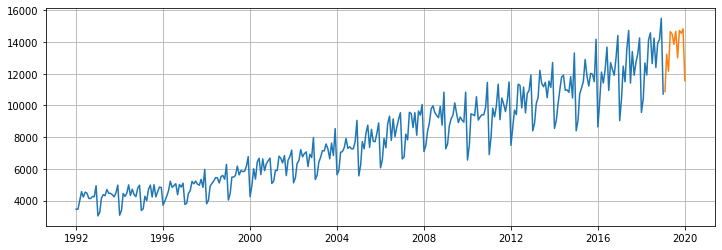

In [47]:
plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(np.arange('1992-01-01', '2019-02-01', dtype='datetime64[M]'), y)
plt.plot(np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]'), true_prediction)

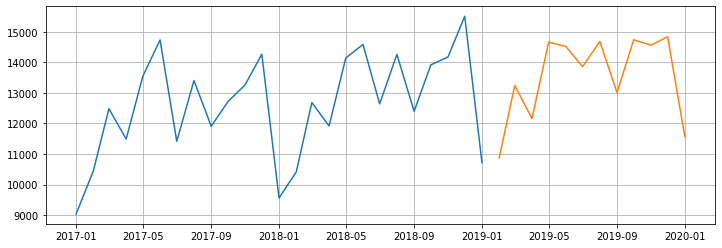

In [52]:
# ZOOM the PLOT.
plt.figure(figsize=(12, 4))
plt.grid()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]'),true_prediction)